(160,)


(0.0, 0.8)

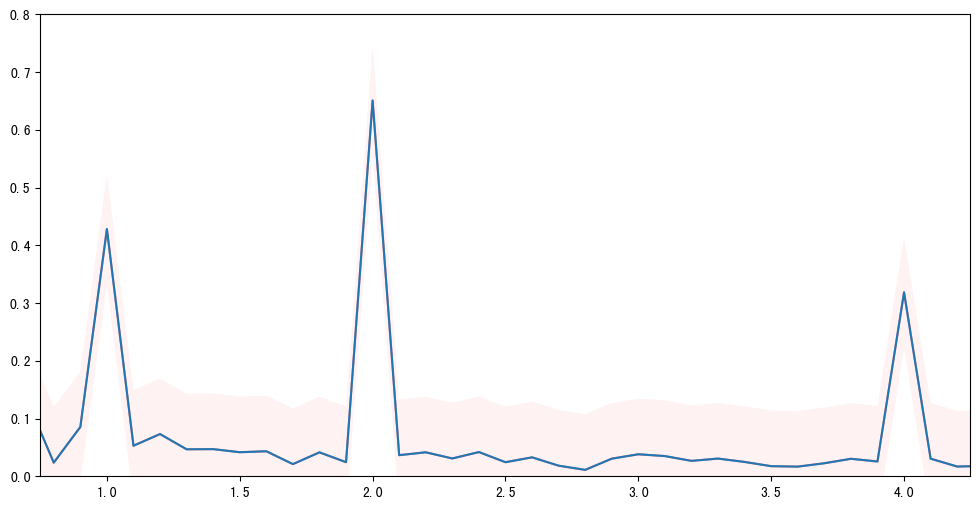

In [124]:
from pylab import *

from scipy.io import loadmat
from scipy import fftpack

# Define the geometric mean function
def geomean(x, axis=None):
    if np.any(x < 0) or not np.isreal(x).all():
        raise ValueError("Input contains negative or non-real values.")
    return np.exp(np.nanmean(np.log(x), axis=axis))


import numpy as np

import numpy as np

def bootstrap_for_vector(B, alpha, bootfun, data, *args):
    np.random.seed(0)  # 固定随机种子（与 MATLAB 一致）
    
    # 检查输入数据是否有全 NaN 的列
    if np.any(np.all(np.isnan(data), axis=0)):
        raise ValueError("Input data contains columns with all NaN values")

    # 计算原始结果，并检查其形状
    try:
        original_result = bootfun(data, axis=0)
        print(original_result.shape)
        if original_result.ndim != 1 or len(original_result) != 160:
            raise ValueError(f"bootfun must return a 1D array of length 160, but got shape {original_result.shape}")
    except Exception as e:
        raise RuntimeError(f"Error evaluating bootfun: {str(e)}")

    # 预分配数组 (1000, 160)，并用 NaN 初始化
    allresults = np.full((B, 160), np.nan)
    valid_count = 0  # 记录有效样本数

    for i in range(B):
        # MATLAB 风格的索引生成（1-based → 0-based）
        rand_values = np.random.rand(data.shape[0])
        indices = np.ceil(data.shape[0] * rand_values) - 1
        indices = indices.astype(int)
        resampled_data = data[indices, :]

        # 检查重采样数据是否有全 NaN 的列
        if np.any(np.all(np.isnan(resampled_data), axis=0)):
            continue  # 跳过无效样本

        try:
            result = bootfun(resampled_data, axis=0)
            if result.shape != (160,):
                raise ValueError(f"bootfun must return shape (160,), but got {result.shape}")
            allresults[valid_count, :] = result  # 存入预分配数组
            valid_count += 1
        except Exception as e:
            print(f"Skipping bootstrap sample {i} due to error: {str(e)}")
            continue

    # 截断无效样本（如果 B=1000 但只有 valid_count 个有效样本）
    if valid_count < B:
        allresults = allresults[:valid_count, :]
        print(f"Warning: Only {valid_count} valid bootstrap samples generated (requested {B})")

    return original_result, allresults

import numpy as np
import matplotlib.pyplot as plt

def plot_shade(x, y_mean, y_std, color, alpha=0.3, ax=None):
    """
    绘制带阴影区域的曲线
    
    参数:
        x : x轴数据
        y_mean : y轴均值数据
        y_std : y轴标准差数据
        color : 颜色 (RGB格式，如[1,0.5,0.5]表示浅红色)
        alpha : 阴影透明度 (默认0.3)
        ax : 要绘制的axes对象 (默认当前axes)
    """
    if ax is None:
        ax = plt.gca()
    
    # 将MATLAB颜色格式转换为Python格式
    py_color = tuple(color)  # 将[1,0.5,0.5]转换为(1,0.5,0.5)
    
    # 计算上下边界
    y_upper = y_mean + y_std
    y_lower = y_mean - y_std
    
    # 绘制阴影区域
    ax.fill_between(x, y_lower, y_upper, color=py_color, alpha=alpha, linewidth=0)
    
    # 绘制均值线
    ax.plot(x, y_mean, color=py_color, linewidth=1.5)


# %% 加载数据部分
# 加载EOG数据
ye_data = loadmat('Data/yeE1.mat')
ye = ye_data['ye']  # 假设MATLAB变量名保存为'ye'

# # 处理EOG数据
# x2 = np.mean(np.mean(ye[:, 0, :, :], axis=1), axis=1).squeeze()  # 第一个通道(索引0)
# v2 = np.mean(np.mean(ye[:, 1, :, :], axis=1), axis=1).squeeze()  # 第二个通道(索引1)

# 加载EEG数据
yb_data = loadmat('Data/ybE1.mat')
yb = yb_data['yb']  # 假设MATLAB变量名保存为'yb'

# 处理EEG数据
yy = np.mean(yb, axis=2).squeeze()          # 平均第三维度
y2 = np.mean(yb[:, 47, :, :], axis=1).squeeze()  # 第48通道(索引47)

# %% 生成时间向量
fs = 128 / 8
t = np.arange(0, 20 + 1/fs, 1/fs) - 2  # 完全复制MATLAB的时间生成逻辑

# Parameters
Bv = 1000
# Adjust the length of the wind array to match the first dimension of y2
wind = (t[:y2.shape[0]] >= 1) & (t[:y2.shape[0]] < 11)
TD = np.sum(wind)

# Fourier transforms and normalization
fy2 = np.fft.fft(y2[wind, :],axis=0)
fy2 = (2 * np.abs(fy2) / TD) ** 2

# fx2 = np.fft.fft(x2[wind, :])
# fx2 = (2 * np.abs(fx2) / TD) ** 2

# fv2 = np.fft.fft(v2[wind, :])
# fv2 = (2 * np.abs(fv2) / TD) ** 2

ff2 = np.fft.fft(yy[wind, :, :])
ff2 = (2 * np.abs(ff2) / TD) ** 2

# Bootstrap for geometric mean
# _, Afx2 = bootstrap_for_vector(Bv, 0.05, geomean, fx2.T)
_, Afy2 = bootstrap_for_vector(Bv, 0.05, geomean, fy2.T)
# _, Afv2 = bootstrap_for_vector(Bv, 0.05, geomean, fv2.T)

# Frequency vector
f = np.arange(fy2.shape[0])
f = f / fy2.shape[0] * fs
fig = figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plot_shade(f, geomean(fy2.T,axis=0), np.std(Afy2), [1, 0.5, 0.5],alpha=0.1)
ax.plot(f,geomean(fy2, axis=1), label='EEG')
ax.set_xlim([.75,4.25])
ax.set_ylim([0,0.8])


(1000, 160)